# <span style="font-size:18pt;"><mark style="background-color: white;">Un panorama des pratiques informatiques dans les publications de recherche dans la base de données HAL.</mark></span>

Un exemple des bonnes pratiques à mettre en place pour constituer un Notebook.

Par POPINEAU Maxime (rapport réalisé en stage de Master 2 coencadré par Marie-Laure Massot, Emilien Schultz et Agnès Tricoche, dans le cadre de l'initiative Digit_Hum, d'avril-juillet 2023).


## <span style="font-size: 14pt"> Information sur les données.</span>

Les données utilisées dans ce notebook proviennent du site HAL (https://hal.science/). L’archive ouverte pluridisciplinaire HAL est destinée au dépôt et à la diffusion en libre accès des travaux scientifiques des chercheurs, émanant des établissements d'enseignement et de recherche français ou étrangers, des laboratoires publics ou privés. Son interface en ligne permet de partager librement les savoirs. Il est également possible d’interagir avec la base de données de HAL via une API*, et notamment de l’interroger pour y effectuer des recherches selon divers critères puis de récupérer les résultats dans différents formats de données structurées.

Une API (Interface de programmation d'application) fournit des "endpoints" permettant d'interagir avec leur site web afin de récupérer des informations grâce à des recherches. Les APIs facilitent la communication entre plusieurs applications informatiques : cela sert à ce que les applications puissent échanger des informations entre-elles. Cela permet aux développeurs de créer des applications utilisant plusieurs APIS en même temps.

L'utilisation d'une API nécessite également une chaîne de requête ("query string" en anglais), qui est une partie à ajouter à droite ,pour l'API de HAL, de l'URL de base pour inclure des paramètres et des valeurs.

Un exemple de chaîne de requête est : https://api.archives-ouvertes.fr/search/?q=%22jupyter%20notebook%22. Cette URL fonctionne directement dans notre navigateur web et renvoie les résultats de notre recherche.

https://api.archives-ouvertes.fr/search est la première partie qui permet d'accéder au serveur des archives ouvertes. La deuxième partie, ?q=%22jupyter%20notebook%22, permet de spécifier notre requête, qui est "jupyter notebook".

Certains caractères, tels que l'espace ou les guillemets doubles, doivent être encodés correctement pour être transmis via le protocole HTTP. Le %22 correspond à l'encodage ASCII du caractère double guillemet et le %20 correspond à l'encodage de l'espace. Cela permet à l'ordinateur d'effectuer la requête sur "jupyter notebook" et non  "jupyter" et "notebook" séparément.

L'utilisation de cette API permet d'interroger les données en utilisant des paramètres, par exemple pour connaître le nombre d'articles publiés dans HAL en 2014.

Dans ce notebook, nous allons voir comment utiliser l'API HAL ainsi que les bibliothèques pandas et matplotlib. 

Pour les personnes qui ne connaissent pas Python.

Un ipywidget est disponible à la fin du Notebook pour permettre à des non-programmeurs d'interagir avec l'API de HAL !

## <span style="font-size: 14pt"> Objectifs de ce Jupyter Notebook.</span>

Ce Jupyter Notebook vise à  :

1. Faire un panorama des pratiques numériques des chercheurs.
2. Fournir un exemple de Jupyter Notebook reproductible et de qualité. 
3. Enseigner des compétences aux utilisateurs débutants ou expérimentés avec Python.

## <span style="font-size: 14pt"> Compétences requises.</span>

Ce Jupyter Notebook est à destination d'un public débutant. Il est préférable de connaître le langage informatique Python pour suivre le Notebook, mais cela n'est pas obligatoire.

Le document permet d'acquérir des compétences variées comme :

1. Savoir utiliser les différentes librairies comme pandas et matplotlib.
2. Utiliser les fonctions en Python pour éviter la duplication du code.
3. Savoir faire une requête via une API.

## Section 0 : Importation des librairies.

Dans cette section, nous allons importer les librairies nécessaires à notre analyse.

Le rôle des libraries

La librairie requests et json permetttent de faire les requêtes via l'API de HAL.

Pandas est utilisé pour faire de l'analyse de données. La librairie fournit des fonctions pour créer, manipuler et analyser des DataFrames (les tableaux).

Matplotlib permet de faire des graphiques et de visualiser les données.

In [1]:
from pyodide.http import pyfetch, FetchResponse
from typing import Optional, Any

async def request(url: str, method: str = "GET", body: Optional[str] = None,
                  headers: Optional[dict[str, str]] = None, **fetch_kwargs: Any) -> FetchResponse:
    """
    Async request function. Pass in Method and make sure to await!
    Parameters:
        url: str = URL to make request to
        method: str = {"GET", "POST", "PUT", "DELETE"} from `JavaScript` global fetch())
        body: str = body as json string. Example, body=json.dumps(my_dict)
        headers: dict[str, str] = header as dict, will be converted to string...
            Example, headers=json.dumps({"Content-Type": "application/json"})
        fetch_kwargs: Any = any other keyword arguments to pass to `pyfetch` (will be passed to `fetch`)
    Return:
        response: pyodide.http.FetchResponse = use with .status or await.json(), etc.
    """

    # kwargs = {"method": method, "mode": "cors"}  # CORS: https://en.wikipedia.org/wiki/Cross-origin_resource_sharing
    kwargs = {"method": method, "mode": "cors", "credentials": "same-origin"}  # CORS: https://en.wikipedia.org/wiki/Cross-origin_resource_sharing
    if body and method not in ["GET", "HEAD"]:
        kwargs["body"] = body
    if headers:
        kwargs["headers"] = headers
    kwargs.update(fetch_kwargs)
    # print(f'url: {url}, args: {kwargs}')
    response = await pyfetch(url, **kwargs)
    # print(f'status: {response.status}')
    return response

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

## Section 1 : Analyse du nombre de publications citant Python et les Jupyter Notebooks.

Nous pouvons faire une analyse statistique du nombre de publications dans la base de données HAL mentionnant Python et les Jupyter Notebooks.

## <span style="font-size: 12pt">1.0 : Utilisation d'une fonction qui retourne le nombre d'articles par année en fonction d'une recherche.</span>

Les fonctions permettent de rendre le code plus lisible et d'éviter de le dupliquer. Elles font parties des bonnes pratiques à adopter dans un notebook.

Pour faire une requête via l'API, il est nécessaire de lire la documentation du site HAL disponible à cette adresse : https://api.archives-ouvertes.fr/docs/search


In [3]:
async def get_publication_counts(query):
    # Effectue une requête pour obtenir le nombre total de publications
    # headers = {"Content-type": "application/json"}
    headers = {}
    # req = requests.get(f"https://api.archives-ouvertes.fr/search/?q=text_fulltext:({query})&rows=0&facet=true&facet.field=publicationDateY_i")
    response = await request(f"https://api.archives-ouvertes.fr/search/?q=text_fulltext:({query})&rows=0&facet=true&facet.field=publicationDateY_i", method="GET", headers=headers)
    req_json = await response.json()
    nb = req_json["response"]["numFound"]
    print(f"Le nombre total de résultats est de : {nb}\n")

    # Effectue une requête pour obtenir le nombre de publications par année
    year_counts = []
    for year in range(1995, 2023):
        response = await request(f"https://api.archives-ouvertes.fr/search/?q=text_fulltext:({query}) AND publicationDateY_i:{year}&rows=0", method="GET", headers=headers)
        req_json = await response.json()
        year_count = req_json["response"]["numFound"]
        year_counts.append((year, year_count))

    # Transforme la liste de tuples en un DataFrame pandas et le renvoie
    df = pd.DataFrame(year_counts, columns=["Année", "Nombre de publications"])
    return df

Nous allons ensuite appelé cette fonction et imprimer le Dataframe créé grâce à la librairie Pandas.

In [4]:
df = await get_publication_counts("python")
print(df)

Le nombre total de résultats est de : 30144

    Année  Nombre de publications
0    1995                       2
1    1996                       1
2    1997                       3
3    1998                       4
4    1999                       7
5    2000                       8
6    2001                      10
7    2002                      14
8    2003                      32
9    2004                      32
10   2005                      68
11   2006                     114
12   2007                     108
13   2008                     161
14   2009                     224
15   2010                     328
16   2011                     445
17   2012                     566
18   2013                     661
19   2014                     877
20   2015                    1047
21   2016                    1387
22   2017                    1934
23   2018                    2612
24   2019                    3605
25   2020                    4157
26   2021                    5175
27 

Le dataframe montre une augmentation importante des articles concernant Python dans la base de donnée HAL. Le nombre d'articles sur Python passe de 10 en 2001 à 444 en 2011 puis 5143 en 2021 soit une multiplication par 500 en l'espace d'une vingtaine d'années. Il est important de noter que l'année 2022 est la première année de baisse du nombre d'articles concernant Python par rapport à l'année précédente depuis 1996.

## <span style="font-size: 12pt">1.1 : Faire un graphique avec la librairie Matplotlib pour voir le nombre de publications sur Python en fonction des années.</span>

Nous allons passer maintenant à la représentation graphique avec la librairie Matplotlib.


Le nombre d'articles contenant le mot clé 'python' est de : 30144



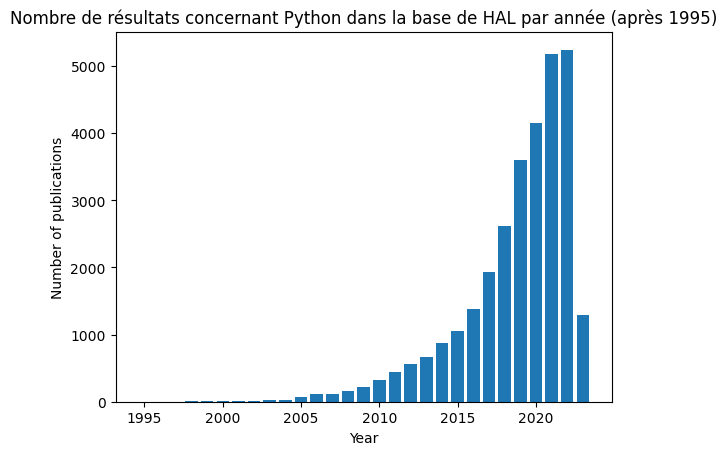

In [5]:
# Effectue une requête pour obtenir le nombre d'articles avec le mot-clé "Python"
headers = {"Content-type": "application/json"}
query = "python"
response = await request(f"https://api.archives-ouvertes.fr/search/?q=text_fulltext:({query})&rows=0&facet=true&facet.field=publicationDateY_i", method="GET", headers=headers)
req_json = await response.json()    
nb = req_json["response"]["numFound"]
print(f"Le nombre d'articles contenant le mot clé '{query}' est de : {nb}\n")

# Effectue une requête pour obtenir le nombre d'articles avec le mot-clé "Python" par année
year_counts = req_json["facet_counts"]["facet_fields"]["publicationDateY_i"]
year_counts = [year_counts[i:i+2] for i in range(0, len(year_counts), 2) if int(year_counts[i]) >= 1995]
years = [int(year) for year, count in year_counts]
counts = [count for year, count in year_counts]

# Création du graphique
plt.bar(years, counts)
plt.title("Nombre de résultats concernant Python dans la base de HAL par année (après 1995)")
plt.xlabel("Year")
plt.ylabel("Number of publications")
plt.show()

Matplotlib nous permet de visualiser l'augmentation du nombre des articles sur Python ces 25 dernières années dans HAL. Nous constatons que l'année 2023 marquera peut être une baisse du nombre d'articles publiés sur Python car cinq mois se sont déjà écoulés et il y a à peine 1000 articles dans la base de données.


### <span style="font-size: 12pt"> 1.2 : Obtenir les résultats pour les Jupyter Notebooks.</span>

Nous appelons la même fonction que dans le 1.0

In [6]:
df = get_publication_counts("jupyter AND (notebook OR notebooks)")
print(df)

<coroutine object get_publication_counts at 0x4ac8278>


Le Dataframe montre une augmentation importante des articles mentionnant les Jupyter Notebooks (avec et sans "s") dans la base de donnée HAL. Ils passent en effet de 12 en 2016 à 70 (multiplé par 5) en 2018 puis à 223 en 2022. Ainsi, le nombre de publications déposées dans HAL citant les Jupyter Notebooks a été multiplé à peu près par 19 entre 2016 et 2022.

Il est néanmoinq important de comparer cette hausse d'intérêt pour Python et pour les Jupyter Notebooks à la hausse du nombre d'articles dans HAL. En effet, cette hausse du nombre d'articles pourrait ne pas être la conséquence d'une hausse d'intérêt mais d'une simple hausse dans le nombre d'articles déposés dans l'archive ouverte.

## <span style="font-size: 12pt"> 1.3 : Calculer le pourcentage d'articles mentionnant Python et les Jupyter Notebooks par rapport au nombre total d'articles publiés dans HAL au cours du temps.</span>

Nous utilisons l'API de HAL et la librairie pandas pour créer un tableau.

In [17]:
# Récupère le nombre total d'articles pour chaque année
total_counts = []
headers = {}
for year in range(1995, 2023):
    req = await request(f"https://api.archives-ouvertes.fr/search/?q=*&fq=producedDateY_i:{year}&rows=0", method='GET', headers=headers)
    req_json = await req.json()
    year_count = req_json["response"]["numFound"]
    total_counts.append((year, year_count))
total_df = pd.DataFrame(total_counts, columns=["year", "total_articles"])

# Récupère le nombre d'articles concernant Python pour chaque année
python_counts = []
for year in range(1995, 2023):
    req = await request(f"https://api.archives-ouvertes.fr/search/?q=text_fulltext:(Python)&fq=producedDateY_i:{year}&rows=0", method='GET', headers=headers)
    req_json = await req.json()
    year_count = req_json.get("response", {}).get("numFound", 0)
    python_counts.append((year, year_count))
python_df = pd.DataFrame(python_counts, columns=["year", "python_articles"])

# le nombre d'articles concernant les Jupyter Notebooks pour chaque année
jupyter_counts = []
for year in range(1995, 2023):
    req = await request(f"https://api.archives-ouvertes.fr/search/?q=text_fulltext:(jupyter AND (notebook OR notebooks))&fq=producedDateY_i:{year}&rows=0", method='GET', headers=headers)
    req_json = await req.json()
    year_count = req_json.get("response", {}).get("numFound", 0)
    jupyter_counts.append((year, year_count))
jupyter_df = pd.DataFrame(jupyter_counts, columns=["year", "jupyter_articles"])

# Fusionne les trois dataframes
merged_df = pd.merge(total_df, python_df, on="year")
merged_df = pd.merge(merged_df, jupyter_df, on="year")

# Calcul le pourcentage des articles concernant Python et les JupyterNotebooks pour chaque année.
merged_df["percent_python"] = merged_df["python_articles"] / merged_df["total_articles"] * 100
merged_df["percent_jupyter"] = merged_df["jupyter_articles"] / merged_df["total_articles"] * 100

# Visualise le tableau
print(merged_df)

    year  total_articles  python_articles  jupyter_articles  percent_python  \
0   1995           22533                2                 0        0.008876   
1   1996           24145                1                 0        0.004142   
2   1997           25887                4                 0        0.015452   
3   1998           27664                4                 0        0.014459   
4   1999           28579                6                 0        0.020994   
5   2000           33232                8                 0        0.024073   
6   2001           35191               10                 0        0.028416   
7   2002           42263               14                 0        0.033126   
8   2003           51682               31                 0        0.059982   
9   2004           63018               34                 0        0.053953   
10  2005           83761               67                 0        0.079989   
11  2006          100035              114           

Le tableau montre que le pourcentage des documents mentionnant Python et les Jupyter Notebooks augmente au fil des années dans le total de documents publiés dans HAL. L'intérêt pour ce langage de programmation et ce type de carnets interactifs semble donc augmenter sensiblement dans le cadre de la recherche.

En effet, si en 2002, les documents relatifs à Python ne représentaient que 0,03% du total des documents présents dans HAL, ce chiffre est passé à 0,37% en 2012 et a atteint 3,31% en 2022. Notons aussi, que le projet Jupyter a été lancé en 2014 et que les premiers résultats apparaissent en 2015 avec un document traitant des Jupyter Notebooks. En 2019, le pourcentage des documents relatifs aux Jupyter Notebooks représentaient 0,05% du nombre total de documents présents dans HAL. Ce chiffre est de 0,14% en 2022. Bien que l'intérêt pour Python et les Jupyter Notebooks soit en hausse, le nombre d'articles les concernant reste relativement faible par rapport au nombre d'articles total dans la base de données de HAL.

## Section 2 : Travail d'analyse sur la recherche "Python" et "Jupyter Notebook".

Cette section permet d'apprendre à faire une requête multicritères dans l'API de HAL pour obtenir un type particulier de documents (articles, communicatoin ou autres) au sein d'une recherche précise (dans notre exemple, la recherche des mots clés "Python" ou "Jupyter Notebook(s)).

Nous verrons aussi comment récupérer dans l'API de HAL le domaine de recherche pour identifier les disciplines qui intègrent le plus les Jupyter Notebooks dans leur pratique de recherche ou d'enseignement. Notre hypothèse étant bien sûr que ces outils sont plus présents en informatique et dans les disciplines scientifiques qu'en sciences humaines et sociales. Cela nous permettra d'affiner l'analyse des résulats obtenus dans les sections précédentes.

## <span style="font-size: 12pt"> 2.0 : Obtenir le type de document en fonction d'une recherche.</span>

In [18]:
async def get_doc_types(query):
    req = await request(f"https://api.archives-ouvertes.fr/search/?q={query}&rows=0&facet=true&facet.field=docType_s", method='GET', headers=headers)
    req_json = await req.json()
    doc_types = req_json["facet_counts"]["facet_fields"]["docType_s"]
    doc_types = [doc_types[i:i+2] for i in range(0, len(doc_types), 2)]
    total_docs = req_json["response"]["numFound"]
    doc_types_dict = {doc_type: count/total_docs*100 for doc_type, count in doc_types}
    return doc_types_dict

Nous rédigeons une fonction que nous invoquerons dans la suite de notre code comme dans la Section 1.

In [21]:
doc_types = await get_doc_types("text_fulltext:(python)")
print(doc_types)

<ipython-input-21-85cd98f4e7c8>:1: RuntimeWarning: coroutine 'get_doc_types' was never awaited
  doc_types = await get_doc_types("text_fulltext:(python)")


{'ART': 47.283041401273884, 'COMM': 25.451167728237795, 'THESE': 12.009023354564755, 'UNDEFINED': 5.347664543524417, 'REPORT': 2.6406581740976645, 'MEM': 2.2458864118895963, 'COUV': 1.479564755838641, 'POSTER': 0.8359872611464968, 'HDR': 0.6833864118895966, 'OTHER': 0.5540074309978769, 'OUV': 0.41467622080679406, 'LECTURE': 0.3284235668789809, 'PROCEEDINGS': 0.21894904458598727, 'SOFTWARE': 0.17582271762208068, 'BLOG': 0.11279193205944799, 'PRESCONF': 0.08957006369426752, 'ISSUE': 0.029856687898089172, 'VIDEO': 0.02322186836518047, 'OTHERREPORT': 0.016587048832271762, 'REPORT_FORM': 0.01326963906581741, 'REPORT_LICE': 0.01326963906581741, 'REPORT_LABO': 0.009952229299363059, 'ETABTHESE': 0.0033174097664543526, 'MAP': 0.0033174097664543526, 'MEMLIC': 0.0033174097664543526, 'REPORT_LPRO': 0.0033174097664543526, 'REPORT_MAST': 0.0033174097664543526, 'SYNTHESE': 0.0033174097664543526, 'TRAD': 0.0033174097664543526, 'CREPORT': 0.0, 'DOUV': 0.0, 'IMG': 0.0, 'MANUAL': 0.0, 'NOTE': 0.0, 'NOTIC

Nous contastons que parmi les documents liés à Python dans la base de données HAL, les articles scientifiques représentent 47%, suivis des communications à 25%, et des thèses à 11%. En revanche, les cours ne représentent qu'une faible proportion de 0,32%.

In [22]:
doc_types = await get_doc_types("jupyter AND (notebook OR notebooks)")
print(doc_types)

{'ART': 39.130434782608695, 'COMM': 32.608695652173914, 'BLOG': 6.521739130434782, 'LECTURE': 6.521739130434782, 'UNDEFINED': 5.434782608695652, 'OUV': 2.1739130434782608, 'REPORT': 2.1739130434782608, 'SOFTWARE': 2.1739130434782608, 'POSTER': 1.0869565217391304, 'THESE': 1.0869565217391304, 'VIDEO': 1.0869565217391304, 'COUV': 0.0, 'CREPORT': 0.0, 'DOUV': 0.0, 'ETABTHESE': 0.0, 'HDR': 0.0, 'IMG': 0.0, 'ISSUE': 0.0, 'MANUAL': 0.0, 'MAP': 0.0, 'MEM': 0.0, 'MEMLIC': 0.0, 'NOTE': 0.0, 'NOTICE': 0.0, 'OTHER': 0.0, 'OTHERREPORT': 0.0, 'PATENT': 0.0, 'PRESCONF': 0.0, 'PROCEEDINGS': 0.0, 'REPACT': 0.0, 'REPORT_COOR': 0.0, 'REPORT_DOCT': 0.0, 'REPORT_ETAB': 0.0, 'REPORT_FORM': 0.0, 'REPORT_FPROJ': 0.0, 'REPORT_GLICE': 0.0, 'REPORT_GMAST': 0.0, 'REPORT_LABO': 0.0, 'REPORT_LICE': 0.0, 'REPORT_LPRO': 0.0, 'REPORT_MAST': 0.0, 'REPORT_RETABINT': 0.0, 'REPORT_RFOINT': 0.0, 'SON': 0.0, 'SYNTHESE': 0.0, 'TRAD': 0.0}


Le constat est le même pour les Jupyter Notebooks : les documents sont à 39% des articles scientifiques, les communications 32% et des blogs à 6,52%. Les cours représentent seulement 6%.

Nous pouvons nous demander aussi dans quelle discipline les Jupyter Notebooks sont utilisés. Notre hypothèse est que ce format est plus utilisé en informatique et dans les disciplines scientifiques comme en physique par exemple.

## <span style="font-size: 12pt"> 2.1 : De quel domaine de recherche relèvent les Jupyter Notebooks? </span>

Nous allons à présent nous intéresser aux disciplines qui mentionnent les Jupyter Notebooks.

In [23]:
# Faire la requête pour obtenir le nombre de documents contenant "jupyter" et "notebook(s)"
req = await request("https://api.archives-ouvertes.fr/search/?q=text_fulltext:(jupyter AND (notebook OR notebooks))&rows=0&facet=true&facet.field=domain_s", method='GET', headers=headers)

# Obtenir les données de la requête au format JSON
req_json = await req.json()

# Extraire le nombre de publications par domaine
domain_counts = req_json["facet_counts"]["facet_fields"]["domain_s"]
domain_counts = [(domain_counts[i], domain_counts[i+1]) for i in range(0, len(domain_counts), 2)]

# Séparer les domaines multiples et leur nombre de documents en entrées individuelles
domain_counts_split = []
for domain_count in domain_counts:
    domains = domain_count[0].split(';')
    for domain in domains:
        domain_counts_split.append((domain.strip(), domain_count[1]))  # Garder le domaine complet

# Calculer le nombre total de documents
total = sum([count for _, count in domain_counts_split])

# Calculer le pourcentage de documents par domaine
domain_percents = [(domain[0], domain[1]/total*100) for domain in domain_counts_split]

# Filtrer les domaines ayant un seul mot et un pourcentage supérieur à 0,5% et supprimer les domaines spécifiques
domain_percents_filtered = [(domain, percent) for domain, percent in domain_percents if percent > 0.5 and len(domain.split()) == 1
                            and not any(domain_specific in domain for domain_specific in ["1.info.info-ai", "1.info.info-bi", "1.phys.astr", "info.info-lg", "sdv.neu", "sdu.ocean", "math.math-st"])]

# Supprimer les domaines qui commencent par "1"
domain_percents_filtered = [(domain, percent) for domain, percent in domain_percents_filtered if not domain.startswith("1")]

# Créer un dataframe à partir des pourcentages filtrés et trier par ordre décroissant
df = pd.DataFrame(domain_percents_filtered, columns=["Domaine", "Pourcentage"])
df = df.sort_values(by=["Pourcentage"], ascending=False)

# Afficher le dataframe
print(df)

<ipython-input-23-a8a7a5f98a5e>:32: RuntimeWarning: coroutine 'get_publication_counts' was never awaited
  df = pd.DataFrame(domain_percents_filtered, columns=["Domaine", "Pourcentage"])


   Domaine  Pourcentage
0   0.info    17.922875
1    0.sdv     7.099036
2   0.phys     4.469763
3    0.sdu     4.119194
4    0.shs     3.856266
5   0.math     3.067485
6    0.spi     2.892200
7    0.sde     1.840491
8   0.stat     1.621385
9   0.scco     1.139351
10  0.chim     1.051709


Les résultats obtenus confirment notre hypothèse. Les Jupyter Notebooks commencent à être utilisés dans les disciplines SHS, mais très peu : 3,8%. L'évolution de l'utilisation des Notebooks est plus marquée en informatique : (17%) en Sciences de la Vie (7%) ou bien en physique (4,4%).

En effet, il y a encore peu de Notebooks en SHS que cela soit en Histoire ou en Géographie (sans parler de l'archéologie, de la la littérature ou de la philosophie). Une explication pourrait être que la pratique des Notebooks en SHS est nouvelle et aussi que les sciences sociales ont moins besoin d'utiliser des langages de programmation dans leur pratique quotidienne. 

Enfin, le manque de ressources pour se former et cas d'études sur l'utilisation des Jupyter Notebooks dans le cadre des SHS semblent un frein à l'appropriation de cet outil par les praticiens SHS.

## Section 3 : Travail général sur les pratiques numériques des chercheurs.

Nous allons voir dans cette partie quels sont les logiciels et les différents langages informatiques (autre que Python) que les chercheurs utilisent le plus dans la base de HAL.

## <span style="font-size: 12pt"> 3.0 : Les autres pratiques numériques des chercheurs.</span>

In [24]:
# Liste des termes de recherche
terms = ["langage de programmation Julia", "Rstudio", "Python", "pascal langage informatique", "Matlab", "Javascript", "Spss", "Stata", "Fortran", "Javascript", "Bash", "Rust", "SAS", "Excel", "Libreoffice", "Perl", "HTML"]

# Dictionnaire pour stocker les résultats
results = {}

# Pour chaque terme de recherche, faire une requête et extraire le nombre total de résultats
for term in terms:
    req = await request(f"https://api.archives-ouvertes.fr/search/?q={term}&rows=0", method='GET', headers=headers)
    req_json = await req.json()
    total = req_json["response"]["numFound"]
    results[term] = total

# Afficher les résultats sous forme de tableau
import pandas as pd

df = pd.DataFrame.from_dict(results, orient="index", columns=["Nombre de documents"])
df = df.sort_values(by=["Nombre de documents"], ascending=False)

print(df)

                                Nombre de documents
SAS                                           10826
Matlab                                         2868
HTML                                           2741
Python                                         2654
Rust                                           1121
Perl                                            854
Excel                                           672
Fortran                                         546
Javascript                                      434
Stata                                           428
Spss                                            364
pascal langage informatique                     217
Bash                                             47
Rstudio                                          43
Libreoffice                                      12
langage de programmation Julia                    8


Il est intéressant de voir les différentes pratiques numériques des chercheurs. Python a pris beaucoup d'importance mais il est important de voir que les chercheurs utilisent aussi d'autres langages informatiques comme HTML, Perl, Pascal ou bien Javascript. Les chercheurs utilisent aussi des logiciels comme Rstudio, LibreOffice mais surtout Excel.

## <span style="font-size: 12pt"> 3.1 : Les principaux types de documents.</span>

Il est important de voir les autres pratiques numériques des chercheurs anglais ou français et de comparer le type de document produit dans la plateforme HAL.

In [26]:
# Liste des termes de recherche
terms = ["langage de programmation Julia", "Rstudio", "Python", "pascal langage informatique", "Matlab", "Javascript", "Spss", "Stata", "Fortran", "Javascript", "Bash", "Rust", "SAS", "Excel", "Libreoffice", "Perl", "HTML"]

# Dictionnaire pour stocker les résultats
results = {}

# Pour chaque terme de recherche, faire une requête et extraire les pourcentages de chaque type de document
for term in terms:
    doc_types_dict = await get_doc_types(term)
    results[term] = doc_types_dict

# Afficher les résultats sous forme de tableau
df_list = []
for term, doc_types_dict in results.items():
    df = pd.DataFrame.from_dict(doc_types_dict, orient="index", columns=[term])
    df = df.loc[df[term] > 0].sort_values(by=[term], ascending=False).head(3)
    df.dropna(axis=1, inplace=True)
    df_list.append(df)

df_final = pd.concat(df_list, axis=1)
df_final.fillna("", inplace=True)
df_final.dropna(axis=0, how='all', inplace=True)
print(df_final)

<ipython-input-26-1cd59d51d6f1>:5: RuntimeWarning: coroutine 'get_doc_types' was never awaited
  results = {}


          langage de programmation Julia    Rstudio     Python  \
COMM                                62.5   32.55814  24.604371   
THESE                               25.0              6.443105   
LECTURE                             12.5                         
ART                                       25.581395  48.078372   
REPORT                                     9.302326              
COUV                                                             
POSTER                                                           
MEM                                                              
BLOG                                                             
UNDEFINED                                                        
OTHER                                                            

          pascal langage informatique     Matlab Javascript       Spss  \
COMM                        42.396313  41.875872   54.83871  17.307692   
THESE                       12.903226  14.191074   6.912442

D'après les résultats obtenus, il apparaît que les types de documents les plus fréquemment associés à nos termes de recherche sont très majoritairement soit des articles scientifiques ou des communications ce qui est le même résultat que pour "Python" et les "Jupyter Notebooks" obtenu dans la section 2.0

Nous avons vu comment mettre des paramètres avec le "query string" mais il y a une autre manière de faire.

Nous pouvons construire un dictionnaire et ensuite passer le dictionnaire en tant qu'argument à la fonction requests.get. Lorsque la requête est effectuée, la bibliothèque requests construit automatiquement l'URL avec les paramètres spécifiés dans le dictionnaire.

Cela permet de spécifier les paramètres de manière plus structurée et flexible, en utilisant une syntaxe de dictionnaire.

In [27]:
# Effectuer une requête pour obtenir les types de document pour tous les documents dans HAL
params = {
    "q": "*:*",
    "rows": 0,
    "fl": "docType_s",
    "facet": "true",
    "facet.field": "docType_s"
}
req = await request("https://api.archives-ouvertes.fr/search/", params=params, method='GET', headers=headers)
req_json = await req.json()

# Extraire les types de document et leurs nombres de la réponse JSON
doc_types = req_json["facet_counts"]["facet_fields"]["docType_s"]
doc_types_dict = {doc_type: count for doc_type, count in zip(doc_types[::2], doc_types[1::2])}

# Créer un DataFrame à partir des types de document
df = pd.DataFrame.from_dict(doc_types_dict, orient="index", columns=["Nombre de documents"])
df = df.sort_values(by=["Nombre de documents"], ascending=False)

# Calculer les pourcentages de chaque type de document par rapport au total
total_documents = df["Nombre de documents"].sum()
df["Pourcentage"] = df["Nombre de documents"] / total_documents * 100

# Afficher le DataFrame
print(df)

dict_keys(['response'])


/lib/python311.zip/ast.py:50: RuntimeWarning: coroutine 'get_doc_types' was never awaited


<class 'KeyError'>: 'facet_counts'

En analysant le nombre total de documents dans la base de HAL, on constate que les deux types de documents les plus fréquents sont des articles scientifiques et des communications. 
Nous pouvons comparer cela aux résultats obtenus pour "Python" et les "Jupyter Notebooks" dans la section 2.

Pour Python, les articles (47%) et les communications (25%) représentent 72% des documents présents. 
Pour les Jupyter Notebooks, les articles (39%) et les communications (32%) représentent 71% des documents présents.

Les résultats sont donc similaires pour l'ensemble des documents, les articles scientifiques (47%) et les communications (23%) représentent aussi la majorité des documents dans la base HAL avec environ 70% des documents présents.

Pour finir notre Notebook interactif, voici l'ipywidget comme promis en introduction pour les utilisateurs non programmeurs mais intéréssés pour interagir avec le document !

Les IpyWidgets permettent à des utilisateurs qui ne savent pas coder d'utiliser l'API des HAL avec des paramètres comme le type de documents ou les années.

In [2]:
%pip install -q ipywidgets

In [5]:
# import requests
import asyncio
import ipywidgets as widgets
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
import json

# Fonction pour effectuer la requête sur l'API HAL
async def make_hal_request(query, year, doc_type):
    headers = {}
    url = f"https://api.archives-ouvertes.fr/search/?q={query}&fq=docType_s:{doc_type}&fq=producedDateY_i:{year}&wt=json"
    response = await request(url, method='GET', headers=headers)
    try:
        data = await response.json()
        return data
    except json.JSONDecodeError:
        print('Erreur lors de l\'analyse de la réponse JSON de l\'API.')
        return None

# Options de requête
doc_types = ['ART', 'COMM', 'OUV', 'THESE']

# Création des widgets
query_widget = widgets.Textarea(value='', placeholder='Saisissez votre requête ici', description='Requête:')
year_widget = widgets.Dropdown(options=['Toutes les années'] + list(range(2010, 2023)), description='Année:')
doc_type_widget = widgets.Dropdown(options=['Tous les types'] + doc_types, description='Type de document:')
display_type_widget = widgets.RadioButtons(options=['Tableau', 'Graphique'], description='Affichage:')
button = widgets.Button(description='Effectuer la requête')

# Fonction de rappel du bouton
def on_button_click(b):
    query = query_widget.value.strip()
    year = year_widget.value
    doc_type = doc_type_widget.value
    
    # Vérification de la validité de la requête
    if not query:
        print('Veuillez saisir une requête valide.')
        return
    
    # Si l'option "Toutes les années" est sélectionnée, on utilise un caractère générique '*' pour la requête
    if year == 'Toutes les années':
        year = '*'
    
    # Si l'option "Tous les types" est sélectionnée, on utilise un caractère générique '*' pour le type de document
    if doc_type == 'Tous les types':
        doc_type = '*'
        
    print(f'query: {query}')
    
    # Appel de la fonction pour effectuer la requête
    data = asyncio.run(make_hal_request(query, year, doc_type))
    
    # Vérification de la réponse de l'API
    if data is None:
        return
    
    # Traitement des résultats
    num_results = data['response']['numFound']
    print(f"Nombre total de documents : {num_results}")
    
    # Exemple d'affichage sous forme de tableau
    if display_type_widget.value == 'Tableau':
        if year == '*':
            if doc_type == '*':
                years = list(range(2010, 2023))
                counts = []
                for year in years:
                    data = make_hal_request(query, year, doc_type)
                    if data is not None:
                        counts.append(data['response']['numFound'])
                
                df = pd.DataFrame({'Année': years, 'Nombre de documents': counts})
                display(df)
            else:
                print('Veuillez sélectionner "Toutes les années" pour afficher les résultats sous forme de tableau.')
        else:
            print('Veuillez sélectionner "Toutes les années" pour afficher les résultats sous forme de tableau.')
    
    # Exemple d'affichage sous forme de graphique
    elif display_type_widget.value == 'Graphique':
        if year == '*':
            if doc_type == '*':
                years = list(range(2010, 2023))
                counts = []
                for year in years:
                    data = make_hal_request(query, year, doc_type)
                    if data is not None:
                        counts.append(data['response']['numFound'])
                
                plt.figure(figsize=(10, 6))
                plt.plot(years, counts, marker='o')
                plt.xlabel('Année')
                plt.ylabel("Nombre de documents")
                plt.title('Nombre de documents publiés par année')
                plt.show()
            else:
                print('Veuillez sélectionner "Toutes les années" pour afficher les résultats sous forme de graphique.')
        else:
            print('Veuillez sélectionner "Toutes les années" pour afficher les résultats sous forme de graphique.')

# Lier la fonction de rappel au bouton
button.on_click(on_button_click)

# Afficher les widgets
display(query_widget, year_widget, doc_type_widget, display_type_widget, button)


Textarea(value='', description='Requête:', placeholder='Saisissez votre requête ici')

Dropdown(description='Année:', options=('Toutes les années', 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2…

Dropdown(description='Type de document:', options=('Tous les types', 'ART', 'COMM', 'OUV', 'THESE'), value='To…

RadioButtons(description='Affichage:', options=('Tableau', 'Graphique'), value='Tableau')

Button(description='Effectuer la requête', style=ButtonStyle())

In [6]:
button.click()

query: (python)


<class 'RuntimeError'>: asyncio.run() cannot be called from a running event loop

Notre Jupyter Notebook est fini : en espérant qu'il vous a plu et qu'il était clair !

Si vous avez des questions ou des retours, merci de m'écrire à mon adresse email universitaire : maxime.popineau@etu.univ-tours.fr.